In [ ]:
## Gauss-Newton Verfahren

[-0.12206825 -0.21848183 -0.16567583  0.05735301  0.08609922 -0.07837572
 -0.04427742  0.07270818  0.05578182 -0.02565156] [[ 0.8718635  -0.04359318  0.01210215  0.12102147]
 [ 0.70103635 -0.10515545 -0.03592482 -0.1197494 ]
 [ 0.02064835 -0.00722692 -0.17365454 -0.24807792]
 [-0.29929398  0.17957639 -0.02026782 -0.01688985]
 [-0.09380156  0.07504125  0.14302665  0.08939165]
 [ 0.10724856 -0.11797341  0.03062442  0.01392019]
 [ 0.02144517 -0.02895098 -0.08598436 -0.03184606]
 [-0.03458363  0.05360463 -0.04474651 -0.01443436]
 [-0.02643636  0.04626364  0.02554044  0.00729727]
 [ 0.00269687 -0.0052589   0.03911983  0.01003073]]
k x1	 x2	 x3	 x4	 r		 s
1 0.685 0.691 	 3.017 	 0.414 	 3.170e-01	 1.271e+00
2 0.723 0.803 	 3.069 	 0.606 	 1.415e-01	 8.993e-01
3 0.736 0.798 	 3.075 	 0.603 	 2.100e-02	 7.899e-01
4 0.735 0.796 	 3.074 	 0.604 	 2.620e-04	 7.606e-01
5 0.735 0.796 	 3.075 	 0.604 	 7.740e-05	 7.607e-01
6 0.735 0.796 	 3.074 	 0.604 	 2.204e-05	 7.607e-01
7 0.735 0.796 	 3.075 	 

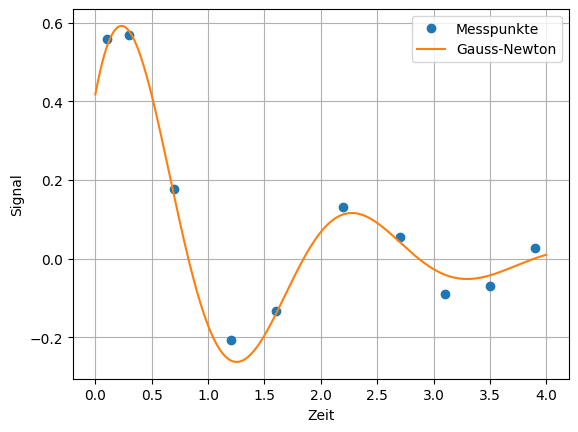

In [7]:
import sys, os
from matplotlib.pylab import cholesky
import numpy as np
import matplotlib.pyplot as plt
#import numerik_functions as nf  # Importiert numerik_functions.py als nf
from scipy.linalg import solve_triangular,lu,lu_solve


#s0=100
#x0 =80300

# Parameter for Gauss-Newton test
tk = np.array([0.1, 0.3, 0.7, 1.2, 1.6, 2.2, 2.7, 3.1, 3.5, 3.9])
yk = np.array([0.558, 0.569, 0.176, -0.207, -0.133, 0.132, 0.055, -0.090, -0.069, 0.027])

# Gauss-Newton Algorithmus
def gauss_newton(function, jacobi, x0, xdata, ydata, tol=1e-6, max_iter=100, damped=False, maxDampingIter=100):
    """
    Gauss-Newton Algorithmus für nicht lineare Gleichungen

    Eingabe
    function:   Funktion welche gefitet werden soll
    jacobi:     Jakobi-Matrix der Funktion welche gefittet werden soll: Jacobi = Df(x)
    x0:         Erster Schätzwert der Parameter. Müssen in der nähe der Lösung liegen damit der Algorithmus konvergiert.
    ydata:      Vektor mit Messdaten
    xdata:      Vektor mit Zeitdaten
    max_iter:   Maximale Interationsschritte (default: 100)
    tol:        Toleranz der Kovnergenz (default: 1e-6)

    Rückgabe:
    parameter:  Lösungsvektor, Zahlen der Parameter, damit die Lösung den kleinsten fehler Quadrate der Messdaten entspricht
    """

    k = 0 #Anzahl Interationen
    parameter = x0.copy() #muss in der nähe der Lösung liegen damit es konvergiert
    y = function(xdata, parameter) - ydata
    j = jacobi(xdata, parameter)

    r = np.array([np.linalg.norm(j.T@y)])
    print("k", "x1\t", "x2\t", "x3\t", "x4\t", "r\t\t", "s")
    
    while r > tol and k < max_iter:
        j = jacobi(xdata, parameter)
        y = function(xdata, parameter) - ydata
       
        # Normalengleichung lösen
        #deltax = np.linalg.solve(j.T@j, -j.T@y)

        # Mit QR-Zerlegung
        Q,R = np.linalg.qr(j)
        deltax = solve_triangular(R, -Q.T@y, lower=False)
        # Falls Dämpfung aktiviert ist
        if damped == True:
            delta_k = 1
            n = 1
            while  np.linalg.norm(parameter + deltax*delta_k) > np.linalg.norm(parameter) and n < maxDampingIter:
                print("Dämpfung", n)
                delta_k = delta_k / 2
                n = n + 1
            deltax = deltax*delta_k

        parameter = parameter + deltax
        k += 1

        r = np.linalg.norm(j.T@y)
        s = np.sum((y-function(xdata, parameter))**2)
        print(k, round(parameter[0], 3), 
               round(parameter[1], 3), "\t",
               round(parameter[2], 3), "\t",
               round(parameter[3], 3),"\t",
               "{:.3e}\t".format(r),
               "{:.3e}".format(s))

    return parameter


def model(t, x):
    return x[0]*np.exp(-x[1]*t)*np.sin(x[2]*t+x[3])

def jacobi(t, x):
    J =  np.array([        np.exp(-x[1]*t)*np.sin(x[2]*t+x[3]),
                   -x[0]*t*np.exp(-x[1]*t)*np.sin(x[2]*t+x[3]),
                    x[0]*t*np.exp(-x[1]*t)*np.cos(x[2]*t+x[3]),
                     x[0]*np.exp(-x[1]*t)*np.cos(x[2]*t+x[3])])
    return J.T



startwerte = np.array([0.5, 1, 3, 1])
alpha = gauss_newton(model, jacobi, startwerte, tk, yk, tol=1e-6, max_iter=100)
print(alpha)

# Grössere Anzahl an Messpunkten
time = np.linspace(0,4,501)

# Messpunkte und gefittete Funktion plotten
plt.plot(tk, yk, 'o', label='Messpunkte')
plt.plot(time, model(time, alpha),'-', label='Gauss-Newton')
plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()

## 1.4 Industrielle Anwendung aus der Gas Analytik

[ 7.83137901  7.86307305  7.80443506 ... -0.03834229 -0.11450083
 -0.02679522] [[ 9.44943820e-01  9.99999999e-01  0.00000000e+00 ...  0.00000000e+00
  -1.48642848e-01  1.79396542e-02]
 [ 9.45240775e-01  9.99999999e-01  1.00000008e-03 ...  8.88178420e-10
  -1.48311326e-01  1.78485005e-02]
 [ 9.45537066e-01  9.99999999e-01  1.99999928e-03 ...  7.99360578e-09
  -1.47979091e-01  1.77574906e-02]
 ...
 [ 8.33530235e-01  9.99999999e-01  9.98000001e-01 ...  9.94011992e-01
   2.14132070e-01  4.78474425e-02]
 [ 8.33101861e-01  9.99999999e-01  9.99000001e-01 ...  9.97002999e-01
   2.14242142e-01  4.79459139e-02]
 [ 8.32673267e-01  9.99999999e-01  1.00000000e+00 ...  1.00000000e+00
   2.14351534e-01  4.80443099e-02]]
k x1	 x2	 x3	 x4	 r		 s
1 6084.209 -6124.904 	 -617.592 	 2362.955 	 1.793e+03	 7.177e+08
2 -124633.038 95395.179 	 -1.576 	 -52.25 	 1.349e+06	 2.246e+11
3 -125420.402 118128.949 	 29.055 	 -52.212 	 1.190e+08	 2.669e+11
4 -121584.424 138959.063 	 21.919 	 -52.221 	 3.549e+06	 5.672e

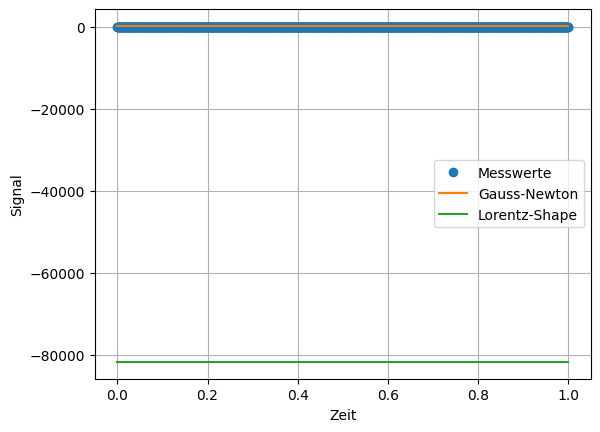

In [9]:
## Teil 2
data = np.genfromtxt('dataP7.txt')
t_gas = data[:,0]         
y_gas = data[:,1] 

def lorentz(t, x):
    return x[0] / (1 + ((t - x[5]) / (x[6]*0.5))**2)

def model_Gas(t, x):
    #x1 = x[0] / (1 + ((t-x[5]) / (x[6]*0.5))**2)
    #x2 = x[1]
    #x3 = x[2]*t
    #x4 = x[3]*t**2
    #x5 = x[4]*t**3
    return x[0] / (1 + ((t-x[5]) / (x[6]*0.5))**2) + x[1] + x[2]*t + x[3]*t**2 + x[4]*t**3

def jacobi_Gas(t, x, h=1e-6):
    
    #J = np.array([1 / (1 + ((t - x[5]) / (x[6]*0.5))**2),
    #              1,
    #              t,
    #              t**2,
    #              t**3,
    #              2*x[0]*t / (1 + ((t - x[5]) / (x[6]*0.5))**2)**2,
    #              2*x[0]*(t - x[5]) / (1 + ((t - x[5]) / (x[6]*0.5))**2)**3]):
    n = len(t)
    m = len(x)
    J = np.zeros((n, m))
    
    for i in range(m):
        params_plus = x.copy()
        params_plus[i] += h
        params_minus = x.copy()
        params_minus[i] -= h
        
        
        df = (model_Gas(t, params_plus) - model_Gas(t, params_minus)) / (2 * h)
        
        J[:, i] = df
    
    return J



#Skalieren
t_gas_min = t_gas[0]
t_gas_old = t_gas
t_gas = (t_gas - t_gas_min)/(t_gas[-1]-t_gas_min)


startwerte_Gas = np.array([0.5, 8.3, -20, 14, 0.085, 0.35, 2.9],dtype=float)
xk_high = startwerte_Gas * 1.1
xk_low = startwerte_Gas *0.8



alpha_Gas = gauss_newton(model_Gas, jacobi_Gas, startwerte_Gas, t_gas, y_gas, tol=1e-6, max_iter=200)



plt.plot(t_gas,y_gas,'o', label='Messwerte')
plt.plot(t_gas, model_Gas(t_gas, alpha_Gas),'-', label='Gauss-Newton')
plt.plot(t_gas, lorentz(t_gas, alpha_Gas),'-', label='Lorentz-Shape')
plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()